In [33]:
#ライブラリの用意
from bs4 import BeautifulSoup
import requests
import re
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
import itertools as itt

In [34]:
#CiNiiから論文タイトルのデータを取得
url = ''
res = requests.get(url)
soup = BeautifulSoup(res.text, 'html.parser')
tag_obj = soup.find_all('a', class_='taggedlink')
title_list = [[obj.text] for obj in tag_obj] #論文ごとのトークン化のためにタイトルを論文ごとにリスト化

In [35]:
stopwords1 = stopwords.words('english') #stopwordsの設定
stopwords2 = ['(', ')', ':', '[', ']', ','] #分析対象に合わせての任意のstopwords
stopwords = stopwords1 + stopwords2

In [36]:
token_list = [] #トークン化
for title in title_list:
    for text in title:
        tokens = nltk.word_tokenize(text)
        tokens = [token.lower() for token in tokens if token not in stopwords]
        tokens = [token for token in tokens if not re.match('\d+', token)] #数字だけのものを除外
        token_list.append(tokens)

In [37]:
freq = defaultdict(int) #頻度カウント用

for tokens in token_list: 
    for token in tokens:
        freq[token] +=1

mod_token_list = []
for tokens in token_list:
    mod_tokens = [token for token in tokens if  freq[token] > 1] #出てくる頻度が1に満たない単語を除外
    mod_token_list.append(mod_tokens)

In [38]:
comb_list = [] #共起する組み合わせの作成
for mod_token in mod_token_list:
    comb = list(itt.combinations(mod_token, 2))
    comb = [tuple(sorted(c)) for c in comb]
    comb = [(x, y) for (x, y) in comb if not x == y]
    comb_list.append(comb)

In [39]:
extend_comb_list = [] #論文ごとにまとめていたトークンと共出現を一つにまとめる
extend_token_list = []

for i in range(0, len(comb_list)):
    extend_comb_list = extend_comb_list + comb_list[i]

for i in range(0, len(mod_token_list)):
    extend_token_list = extend_token_list + mod_token_list[i]

extend_comb_list = list(set(extend_comb_list)) #重複の消去
extend_token_list = list(set(extend_token_list))

In [40]:
comb_freq_for_sent = defaultdict(int) #各共起の組み合わせがいくつの論文に出てきているかカウント

for (x, y) in extend_comb_list:
    for token in mod_token_list:
        if x in token and y in token:
            comb_freq_for_sent[(x, y)] += 1

In [41]:
word_freq_for_sent = defaultdict(int) #各単語がいくつの論文に出てきているかカウント

for x in extend_token_list:
    for token in mod_token_list:
        if x in token:
            word_freq_for_sent[x] += 1

In [42]:
simpson_for_word = defaultdict(float) #各共起の組み合わせに対するシンプソン係数の計算

for (x, y) in extend_comb_list:
    for tokens in mod_token_list:
        simpson_for_word[(x, y)] = comb_freq_for_sent[(x, y)] / min(word_freq_for_sent[x], word_freq_for_sent[y])

simpson_list = sorted(simpson_for_word.items(), key=lambda x:x[1], reverse=True) #降順に並べ直し

In [45]:
import pandas as pd #共起ネットワーク作成用のデータ成型
import numpy as np

In [51]:
word_1 = []
word_2 = []
coef = []

for((x, y), z) in simpson_list:
    word_1.append(x)
    word_2.append(y)
    coef.append(z)
    
df = pd.DataFrame({'word_1':noun_1, 'word_2':noun_2, 'coef':coef}) 
weighted_edges = np.array(df) #重みづけ用のデータ

In [53]:
import matplotlib.pyplot as plt #共起ネットワークの可視化
import networkx as nx
%matplotlib inline

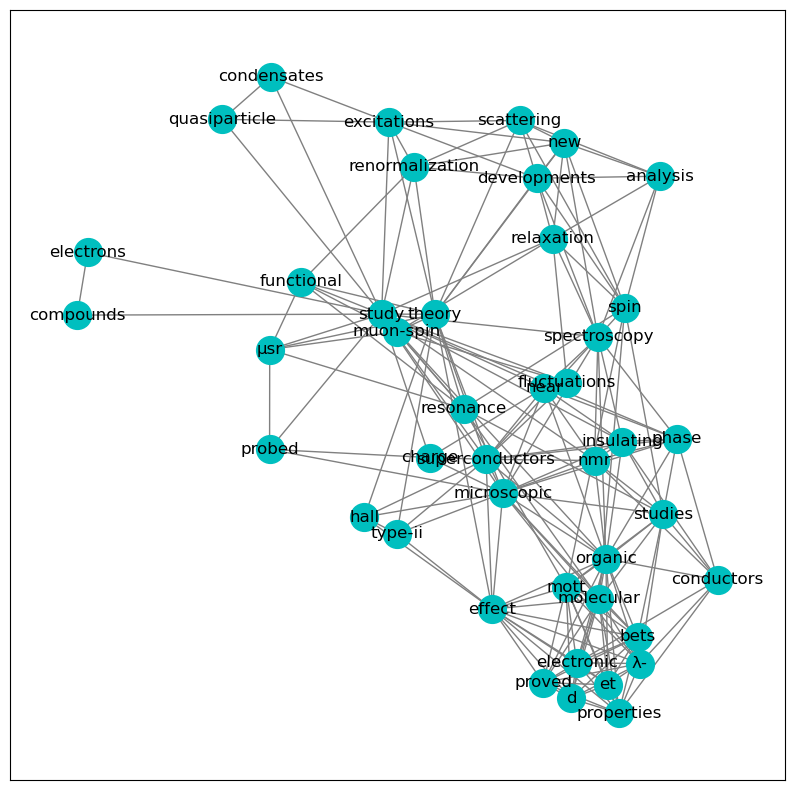

In [67]:
G = nx.Graph() 

G.add_weighted_edges_from(weighted_edges) #重みづけ用データの代入

plt.figure(figsize=(10,10)) #お好みの設定で
nx.draw_networkx(G, node_shape = 'o', node_color = 'c', node_size = 400, edge_color = 'gray', font_family = 'IPAexGothic')
plt.show()